In [139]:
import os, sys
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats

sys.path.insert(0, 'src')
from utils.utils import read_lists

In [47]:
RESULTS_DIR = os.path.join('saved', 'ADE20K', 'survey_results', 'ADE20K_soft_labels')
MEASUREMENT_COLUMN_NAMES = ['selectedAttrs', 'attrUncs']
TASK_METADATA_COLUMN_NAMES = ['filename', 'task', 'concept_group']

CONGRUENCY_PATH_TEMPLATE = os.path.join('saved', 'ADE20K', '0501_105640', 'baseline_explainer', '{}_paths_16_class_freq_attr.txt')
CONGRUENT_PATHS_PATH = CONGRUENCY_PATH_TEMPLATE.format('congruent')
INCONGRUENT_PATHS_PATH = CONGRUENCY_PATH_TEMPLATE.format('incongruent')

# Path to where images in ADE20K are stored. (Prefix to path in congruent/incongruent paths files)
ADE20K_PARENT_DIR = os.path.join('data', 'broden1_224', 'images')
CSV_SAVE_PATH = os.path.join(os.path.dirname(RESULTS_DIR), 'processed_results_{}_samples.csv')



### Obtain list of CSV paths in `RESULTS_DIR`, load congruent and incongruent paths

In [32]:
csv_paths = []

for filename in os.listdir(RESULTS_DIR):
    if filename.endswith('csv'):
        csv_paths.append(os.path.join(RESULTS_DIR, filename))

csv_paths = sorted(csv_paths)
# Load congruent/incongruent paths
congruent_paths = set(read_lists(CONGRUENT_PATHS_PATH))
incongruent_paths = set(read_lists(INCONGRUENT_PATHS_PATH))


In [46]:
df_list = []
for csv_path in csv_paths:
    print("Processing {}".format(os.path.basename(csv_path))) 
    df = pd.read_csv(csv_path)
    measurement_df = df[MEASUREMENT_COLUMN_NAMES]
    metadata_df = df.drop(MEASUREMENT_COLUMN_NAMES, axis=1)
    # print(metadata_df.head())

    # Drop empty rows
    measurement_df = measurement_df.dropna()
    # Drop rows without data in task metadata columns
    metadata_df = metadata_df.dropna(subset=TASK_METADATA_COLUMN_NAMES)

    # Remove columns that are empty
    metadata_df = metadata_df.dropna(axis=1)
    
    # if 'congruent' is not in the dataframe, add it
    if 'congruent' not in metadata_df.columns:
        congruents = []
        for filename in metadata_df['filename']:
            path = os.path.join(ADE20K_PARENT_DIR, filename)
            if path in congruent_paths:
                congruents.append(1)
            elif path in incongruent_paths:
                congruents.append(0)
            else:
                raise ValueError("Path {} not found in congruent or incongruent paths... :0".format(path))
        metadata_df['congruent'] = congruents

    # Assert that the two DFs have the same number of rows
    assert len(metadata_df) == len(measurement_df), "Uneven length data frames. Metadata length: {} Measurement length: {}".format(
        len(metadata_df), len(measurement_df))

    # Reset indices to allow for joining appropriately
    metadata_df = metadata_df.reset_index(drop=True)
    measurement_df = measurement_df.reset_index(drop=True)


    # Join the data frames
    df = pd.concat([metadata_df, measurement_df], axis=1)
    assert len(df) == len(metadata_df)

    df_list.append(df)
    
df = pd.concat(df_list)



Processing 000_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h26.47.486.csv
Processing 001_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h35.07.423.csv
Processing 002_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h40.48.508.csv
Processing 003_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h48.15.198.csv
Processing 004_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h55.01.103.csv
Processing 005_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h00.12.78.csv
Processing 006_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h05.33.934.csv
Processing 007_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h11.11.320.csv
Processing 008_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-04_09h23.31.131.csv
Processing 009_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-04_09h28.52.510.csv
300


In [48]:
save_path = CSV_SAVE_PATH.format(len(df))

if os.path.exists(save_path):
    print("Path {} already exists".format(save_path))
else:
    df.to_csv(save_path)
    print("Saving results to {}".format(save_path))

### Process each uncertainty attribute vector to soft_labels, compute 1) entropy and 2) confusion

In [140]:
SCENE_CATEGORIES_PATH = os.path.join('data', 'ade20k', 'scene_categories.txt')
n_samples = 300

csv_path = CSV_SAVE_PATH.format(n_samples)

# Create a 2-way dictionary mapping from category <-> index
scene_categories = read_lists(SCENE_CATEGORIES_PATH)
scene_categories_dict = {}
for idx, category in enumerate(scene_categories):
    scene_categories_dict[idx] = category
    scene_categories_dict[category] = idx
n_categories = len(scene_categories)

# Load CSV
df = pd.read_csv(csv_path)

In [141]:
def get_top_2_confusion(soft_labels):
    '''
    Given soft label distribution, calculate difference between top 2 labels

    Arg(s):
        soft_labels : N x C np.array
            soft label array for N samples and C class predictions

    Returns:
        confusion : N-dim np.array
            confusion for each sample
    '''
    # Sort soft labels ascending
    sorted_soft_labels = np.sort(soft_labels, axis=-1)
    # Calculate difference of p(x) for top 2 classes
    top_2_difference = sorted_soft_labels[:, -1] - sorted_soft_labels[:, -2]
    # Confusion = 1 - difference (higher is worse)
    top_2_confusion = 1 - top_2_difference

    return top_2_confusion


#### Calculate soft labels, entropy, and top-2 confusion

In [142]:
if 'soft_labels' not in df.columns:
    soft_labels = []
    unmodified_soft_labels = []
    for row in tqdm(df['attrUncs']):
        soft_label = np.zeros(n_categories)
        # Each 'score' item is a dictionary of class and certainty amount
        row = json.loads(row)
        for item in row:
            category = item['label']
            certainty = item['y'] / 100.0
            category_idx = scene_categories_dict[category]
            soft_label[category_idx] = certainty
        label_sum = np.sum(soft_label)
        unmodified_soft_labels.append(soft_label)
        # Distribute remaining mass across other classes
        if label_sum < 1.0:
            remaining = 1.0 - label_sum
            n_classes_left = n_categories - np.count_nonzero(soft_label)
            remaining_per_class = remaining / n_classes_left
            soft_label = np.where(soft_label == 0, remaining_per_class, soft_label)    
        # Normalize to sum to 1
        elif label_sum > 1.0:
            soft_label = soft_label / label_sum
        
        # Assert the soft label sums to 1
        assert np.abs(np.sum(soft_label) - 1.0) < 1e-5

        soft_labels.append(soft_label)

    df['soft_labels'] = soft_labels



In [143]:
# Calculate entropy
entropy = stats.entropy(soft_labels, axis=1)
df['entropy'] = entropy

# Calculate top-2 confusion
top_2_confusion = get_top_2_confusion(soft_labels)
df['top_2_confusion'] = top_2_confusion

In [144]:
# Create a dictionary
soft_labels_arr = np.stack(soft_labels, axis=0)
print(soft_labels_arr.shape)
data = {
    "filename": df['filename'],
    "congruent": df['congruent'],
    "soft_label": soft_labels_arr,
    "entropy": entropy,
    "top_2_confusion": top_2_confusion
}
df.to_csv(csv_path)
print("Saved csv with soft labels to {}".format(csv_path))
pth_path = csv_path.replace('csv', 'pth')
torch.save(data, pth_path)
print("Saved dictionary with filenames, congruency, and soft labels to {}".format(pth_path))
    


(300, 16)
Saved csv with soft labels to saved/ADE20K/survey_results/processed_results_300_samples.csv
Saved dictionary with filenames, congruency, and soft labels to saved/ADE20K/survey_results/processed_results_300_samples.pth


### Examine Results

In [101]:
# save_dir = os.path.join('saved', 'ADE20K', 'survey_results')
# pth_path = os.path.join(save_dir, 'processed_results_300_samples.pth')
# csv_path = os.path.join(save_dir, 'processed_results_300_samples.csv')

# results = torch.load(pth_path)

# filenames = results['filename']
# congruency = results['congruent']
# soft_labels = results['soft_label']

# df = pd.read_csv(csv_path)


In [138]:
# def get_top_2_confusion(soft_labels):
#     '''
#     Given soft label distribution, calculate difference between top 2 labels

#     Arg(s):
#         soft_labels : N x C np.array
#             soft label array for N samples and C class predictions

#     Returns:
#         confusion : N-dim np.array
#             confusion for each sample
#     '''
#     # Sort soft labels ascending
#     sorted_soft_labels = np.sort(soft_labels, axis=-1)
#     # Calculate difference of p(x) for top 2 classes
#     top_2_difference = sorted_soft_labels[:, -1] - sorted_soft_labels[:, -2]
#     # Confusion = 1 - difference (higher is worse)
#     top_2_confusion = 1 - top_2_difference

#     return top_2_confusion


In [137]:
# # Calculate entropy
# entropy = stats.entropy(soft_labels, axis=1)
# df['entropy'] = entropy

# # Calculate top-2 confusion
# top_2_confusion = get_top_2_confusion(soft_labels)
# df['top_2_confusion'] = top_2_confusion

(<Figure size 432x288 with 1 Axes>, <Axes: >)

<Figure size 432x288 with 0 Axes>

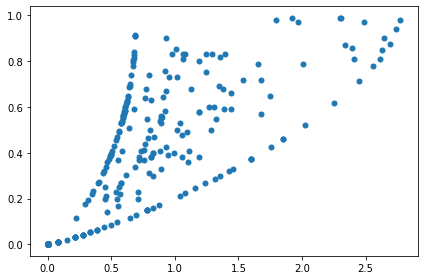

In [136]:
# from utils.visualizations import plot
# plot(
#     xs=[entropy],
#     ys=[top_2_confusion],
#     line=False,
#     marker_size=5
# )